## Tutorial - Sampling Neal's funnel in Bean Machine

Author: Shidi Zhao (zhao5@fb.com)

Please also check the [note](https://fb.workplace.com/notes/nazanin-khosravani-tehrani/bean-machine-ppl/191156018707324/) for more information about Bean Machine’s modeling and inference engine 

The purpose of this tutorial is to showcase a problem where the target density has an unfavorable geometry. We also demonstrate how to implement models with factors in Bean Machine through custom distributions and present some inference methods that Bean Machine provides on this model.

## Problem

Markov chain Monte Carlo (MCMC) methods have difficulty to sample from posteriors with difficult geometries. For instance, Neal's Funnel is one of the target densities that MCMC methods have had difficulty to explore properly because of its particularly sharp neck which has exponential property. So let's start by looking at what is Neals funnel model, and how to implement it in Bean Machine. 

## Prerequisites

Please import the following code packages for the rest of the code in the tutorial to work.

In [176]:
import beanmachine.ppl as bm
from beanmachine.ppl.inference.abstract_infer import (
    VerboseLevel,
)
from torch.autograd import grad
import torch
import torch.distributions as dist
import torch.tensor as tensor
from beanmachine.ppl.diagnostics.common_statistics import effective_sample_size, split_r_hat,r_hat
from scipy.stats import norm
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import plotly
import plotly.graph_objs as go
import numpy as np

plt.rc('figure', figsize=[8, 6])
plt.rc('font', size=14)
plt.rc('lines', linewidth=2.5)

pd.set_option('precision', 3)

torch.manual_seed(11);

## Neal's funnel

Neal's Funnel [Neal 2003](https://projecteuclid.org/euclid.aos/1056562461) provides the classic demonstration of funneling. We consider the joint density of Neal's funnel model as following, for $x\in R^n$,$z\in R$:
   $$
\begin{array}{lcl}
p(z,x) = Normal(z\vert(0,3))\times\prod^n_{i=1}Normal(x_i\vert 0,exp(z/2)) \\
x{\sim} Normal(0,e^{z/2}) \\
z{\sim} Normal(0,3)
\end{array}
$$

Figure 1 shows a contour density plot of this model. As we can see, the funnel’s neck is particularly sharp because of the exponential function applied to z. As x gets closer to 0, z exponentially grows negatively. So it is hard to learn a good scale.

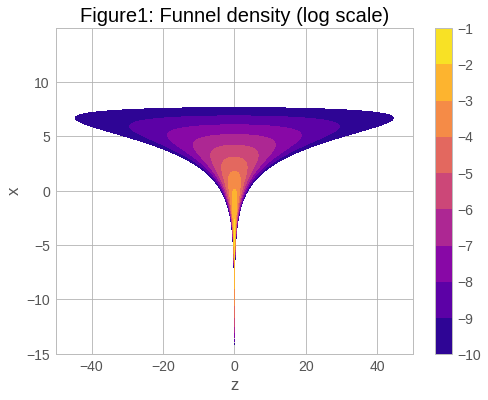

In [177]:
#plot contour

delta = 0.01
x = np.arange(-50,50, delta)
z = np.arange(-15.0, 15.0, delta)
X, Z = np.meshgrid(x, z)
TARGET = dist.Normal(0.0, 3.0).log_prob(tensor(Z)) + dist.Normal(0, (tensor(Z) / 2).exp()).log_prob(tensor(X))

fig, ax = plt.subplots()
cp = ax.contourf(X, Z, TARGET, levels=range(-10, 0, 1), cmap='plasma')
fig.colorbar(cp) 
ax.set_title('Figure1: Funnel density (log scale)')
ax.set_xlabel('z')
ax.set_ylabel('x')
plt.show()

## Model

In Bean Machine, we implement the model using custom distributions. Factors are used in statistical modelings as operators to add values to the target log density. In Bean Machine, random variables are required to return distribution objects which only need to have sample, log_prob, and support implemented. Factors can be easily added to Bean Machine models through custom distributions whose log probs are the values we intend to add to the final target log density. Here, we assign a flat prior to x() and z() at the beginning and directly sample the likelihood using MCMC.

In [111]:
class Flat(dist.Distribution):
    has_enumerate_support = False
    support = dist.constraints.real
    has_rsample = True
    """
    :para infer_type :determine how you are sending the random variable to bean machine. 
    set infer_type == 1, it represent single-site inference, which means you are sending the random variable one by one to Bean machine;
    set infer_type == 2, it represent global inference, you are going to send tensor random variable to Bean machine. 
    
    """
    
    def __init__(self, infer_type=1):
        self.infer_type = infer_type

    def rsample(self, sample_shape):
        return torch.zeros(sample_shape)
    
    def sample(self):
        if self.infer_type==1:
            return torch.tensor(0.0)
        elif self.infer_type==2:
            return torch.tensor([0.0, 0.0])
    
    def log_prob(self, value):
        return torch.tensor(0.0)
    
    
class NealsFunnel(dist.Distribution):
    has_enumerate_support = False
    support = dist.constraints.real
    has_rsample = True
    def __init__(self, x_target, z_target):
        super().__init__()
        self.x_target = x_target
        self.z_target = z_target
    
    def rsample(self, sample_shape):
        return torch.zeros(sample_shape)
    
    def sample(self):
        return torch.tensor(0.0)

    def log_prob(self, value):
        return dist.Normal(0.0, 3.0).log_prob(self.z_target) + dist.Normal(0, (self.z_target / 2).exp()).log_prob(self.x_target)

  

## Inference

Now, we will go through the performance of different inference methods on this model. We will investigate different inference algorithms, Hamiltonian Monte Carlo (HMC) and Newtonian Monte Carlo (NMC) as well as different inference techniques such as single-site and global inference.

###  Single-site inference 

In single-site inference, we re-sample a single random variable and accept or reject this sample individually. In the following example, single-site inference samples the random variables x() and z() separately, and decides to accept or reject them by following Metropolis-Hasting acceptance rule. By doing these, single-site inference can control the variables to be re-sampled depending upon the random variable we wish to infer and its Markov blanket. 

In [112]:
class SingleSite(object):  
    
    @bm.random_variable
    def x(self):
        return Flat(1)

    @bm.random_variable
    def z(self):
        return Flat(1)

    @bm.random_variable
    def target(self):
        return NealsFunnel(self.x(), self.z())

### Global inference

In global inference, on the other hand, we re-sample all random variables together. Once all random variables are re-sampled, we either accept or reject the new samples based on Metropolis-Hastings acceptance probability.

In [113]:
class Global(object):
    
    @bm.random_variable
    def z(self):
        return Flat(2)

    @bm.random_variable
    def target(self):
        return NealsFunnel(self.z()[0], self.z()[1])

So in the following part of the tutorial, we will cover: 
1. How to implement Neal's funnel in Bean Machine (for single-site inference).
2. Run two single-site inference algorithms on the model, single-site Newtonian Monte Carlo (single-site NMC), and single-site Hamiltonian Monte Carlo (single-site HMC).
3. How to implement Neal's funnel in Bean Machine (for global inference).
4. Run two global inference algorithms on the model, global Newtonian Monte Carlo (global NMC), and global Hamiltonian Monte Carlo (global HMC).

We are looking into extending Bean Machine’s inference engine to allow for global inference to run without having to re-implement the model.

### Single-Site NMC

Single-site Newtonian Monte Carlo [(single-site NMC)](https://arxiv.org/abs/2001.05567) is a second-order method, which uses the Hessian to automatically scale the step size in each dimension.

In [162]:
num_sample = 10000
num_trial = 3

nw = bm.SingleSiteNewtonianMonteCarlo()  
model = SingleSite()
samples_nw = nw.infer([model.x(), model.z()], {model.target(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

## Visualizations

Now we can make some plots to visualize our sampling results.

In [163]:
def visualize(label,infer_type,samples, model_x, model_z, color):
    
    if infer_type == 1:
        lim_x = samples[model_x].tolist()[0]
        lim_z = samples[model_z].tolist()[0]
        x_ = samples[model_x].detach()
        z_ = samples[model_z].detach()
    
    elif infer_type == 2:
        lim_x=samples[model_x][:, :, 0].tolist()[0]
        lim_z=samples[model_z][:, :, 1].tolist()[0]
        x_ = samples[model_x].detach()[:, :, 0]
        z_ = samples[model_z].detach()[:, :, 1]
    
    #compute effective sample size and r hat
    print("for "+label+":")
    print("x acceptance", len(torch.unique(x_[0])) / len(x_[0]),", effective sample size", effective_sample_size(x_),", r hat", split_r_hat(x_))
    print("z acceptance", len(torch.unique(z_[0])) / len(z_[0]), ", effective sample size", effective_sample_size(z_),", r hat", split_r_hat(z_))
    
    #scatter plots
    plt.scatter(lim_x,lim_z, s=2, color=color)
    plt.xlim(-150, 150)
    plt.ylim(-15, 15)
    plt.suptitle('Scatter plot_'+label, fontsize=16)
    plt.xlabel("z")
    plt.ylabel("x")

    
    #trace plot
    delta = 0.01
    x = np.arange(-50,50, delta)
    z = np.arange(-15.0, 15.0, delta)
    X, Z = np.meshgrid(x, z)
    TARGET = dist.Normal(0.0, 3.0).log_prob(tensor(Z)) + dist.Normal(0, (tensor(Z) / 2).exp()).log_prob(tensor(X))

    fig, ax = plt.subplots()
    ax.contour(X, Z, TARGET, levels=range(-10, 0, 1))
    plt.plot(x_[0, :100], z_[0, :100], color=color)
    plt.xlabel("z")
    plt.ylabel("x")
    plt.suptitle('Trace plot_'+label, fontsize=16)
    plt.show()
    
    
    #parameterized density histograms
    plt.hist(lim_z, bins = np.linspace(-10, 10, 50), density = True, zorder=0, label=label, color=color)
    s = [0.001 * x for x in range(-10000, 10000)]
    y = [dist.Normal(0, 3).log_prob(x).exp() for x in s]
    plt.plot(s, y, linewidth=2, zorder=2, color="black", label="ground truth")
    plt.xlabel("z")
    plt.ylabel("density")
    plt.suptitle('Parameterized density histograms', fontsize=16)
    plt.legend()
    plt.show()
    
    #autocorrelation
    plt.subplot()
    plt.acorr(lim_x-np.mean(lim_x), maxlags=100,  normed=True, usevlines=False,label="x", color="red");
    plt.xlim( (0, 100))

    plt.acorr(lim_z-np.mean(lim_z), maxlags=100,  normed=True, usevlines=False,label="z", color="blue");
    plt.xlim( (0, 100))
    plt.ylabel(label+"_autocorrelation")
    plt.xlabel("lag")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

for Single-site NMC:
x acceptance 0.9943 , effective sample size tensor(23870.9766) , r hat tensor(1.0000)
z acceptance 0.6585 , effective sample size tensor(1040.4861) , r hat tensor(1.0028)


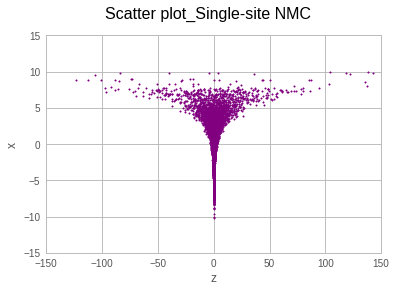

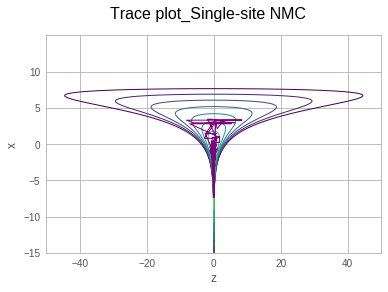

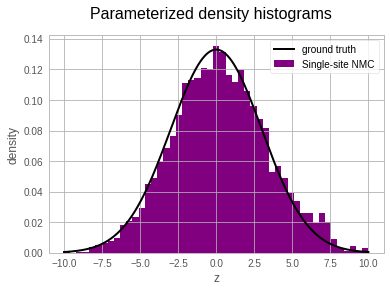

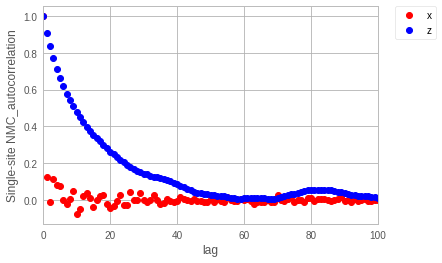

In [164]:
visualize("Single-site NMC",1,samples_nw, model.x(), model.z(), "purple")

From the scatter plot and trace plot, we can see, single-site NMC can explore the negative z region. In single-site NMC  parameterized density histogram, we can see posterior marginal of z in Neal’s funnel after 10,000 samples best match the curvature of the ground truth.

### Single-site HMC

Next, we also sample with single-site HMC inference and compare the results with single-site NMC inference results.

In [165]:
num_sample = 10000
num_trial = 3

step_size = 0.5
num_steps = 1

hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = SingleSite()
samples_hmc = hmc.infer([model.x(), model.z()], {model.target(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

for Single-site HMC_1:
x acceptance 0.6996 , effective sample size tensor(179.8879) , r hat tensor(1.0255)
z acceptance 0.9492 , effective sample size tensor(269.4633) , r hat tensor(1.0127)


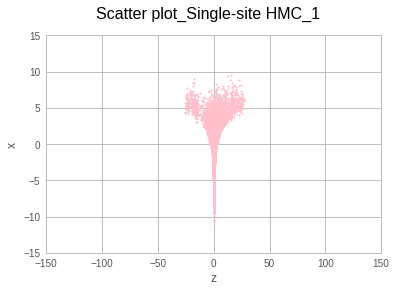

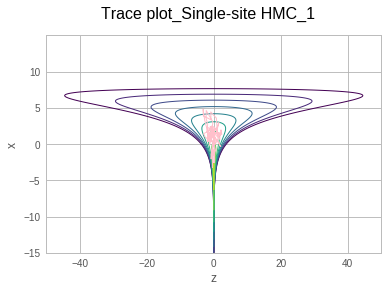

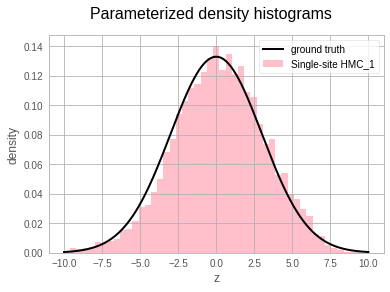

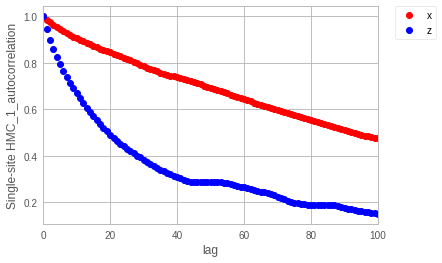

In [166]:
visualize("Single-site HMC_1",1,samples_hmc,model.x(), model.z(),"pink")

### Single-site HMC (changing step size)

In [167]:
num_sample = 10000
num_trial = 3

step_size = 0.1
num_steps = 10

hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = SingleSite()
samples_hmc_10 = hmc.infer([model.x(), model.z()], {model.target(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

for Single-site HMC_10:
x acceptance 0.0046 , effective sample size tensor(81.1953) , r hat tensor(1.0640)
z acceptance 0.0659 , effective sample size tensor(99.8824) , r hat tensor(1.0125)


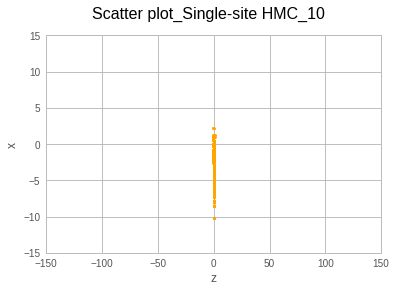

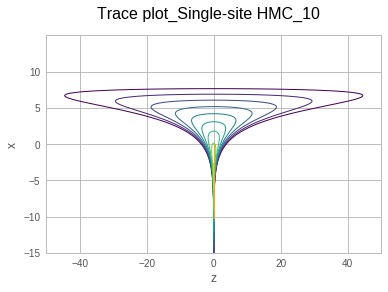

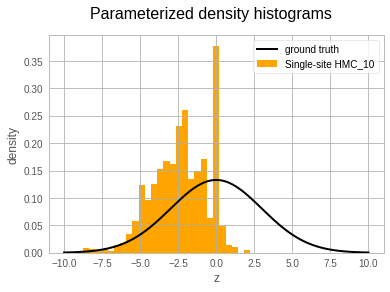

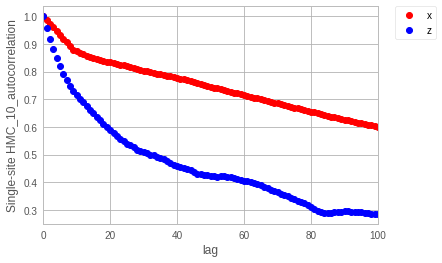

In [168]:
visualize("Single-site HMC_10",1,samples_hmc_10, model.x(), model.z(),"orange")

### Global NMC

In [135]:
%silence 

num_sample = 10000
num_trial = 3

nw = bm.SingleSiteNewtonianMonteCarlo()
model = Global()
samples = nw.infer([model.z()], {model.target(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

for Global NMC:
x acceptance 0.0333 , effective sample size tensor(17.3867) , r hat tensor(1.2474)
z acceptance 0.0333 , effective sample size tensor(2.5879) , r hat tensor(1.9284)


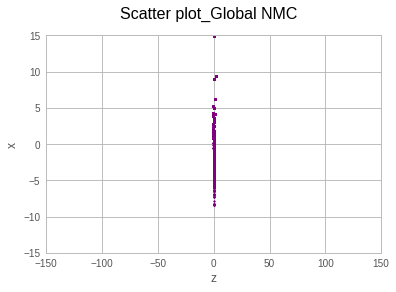

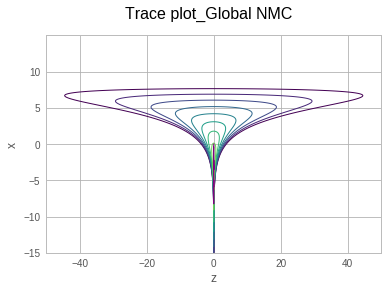

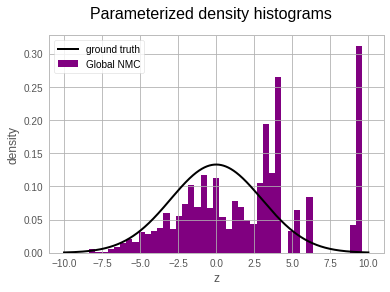

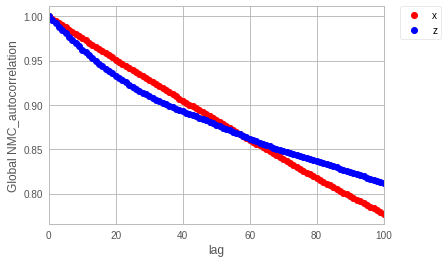

In [159]:
visualize("Global NMC",2,samples, model.z(), model.z(),"purple")

In global inference, since we re-sample all random variables together and accept or reject them together, MCMC would have the problem to explore exponential space. We are continuing to develop the NMC inference algorithm to make it also work in global inference.

### Global HMC 

In [169]:
num_sample = 10000
num_trial = 3

step_size = 0.5
num_steps = 1

hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = Global()
samples_hmc = hmc.infer([model.z()], {model.target(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

for Global HMC_1:
x acceptance 0.6729 , effective sample size tensor(348.9427) , r hat tensor(1.0064)
z acceptance 0.6729 , effective sample size tensor(365.9402) , r hat tensor(1.0073)


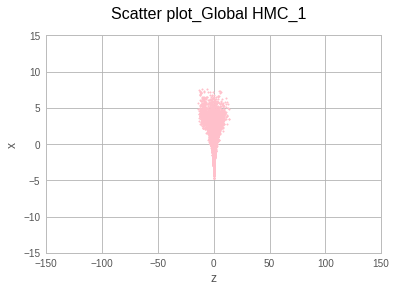

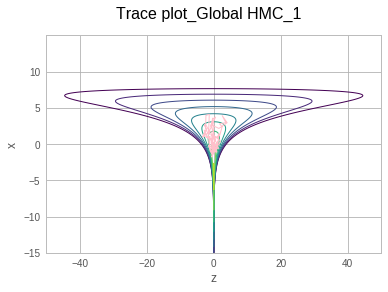

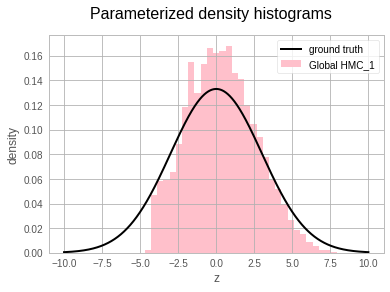

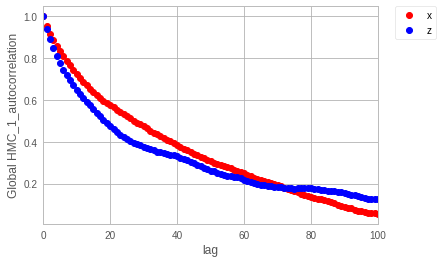

In [171]:
visualize("Global HMC_1",2,samples_hmc, model.z(), model.z(),"pink")

### Global HMC (changing step size)

In [172]:
num_sample = 10000
num_trial = 3

step_size = 0.1
num_steps = 10

hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = Global()
samples_hmc_10 = hmc.infer([model.z()], {model.target(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

for Global HMC_10:
x acceptance 0.0015 , effective sample size tensor(81.4029) , r hat tensor(1.0445)
z acceptance 0.0015 , effective sample size tensor(51.2529) , r hat tensor(1.0451)


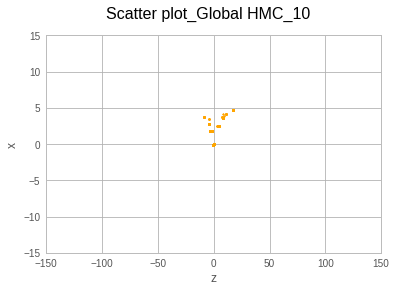

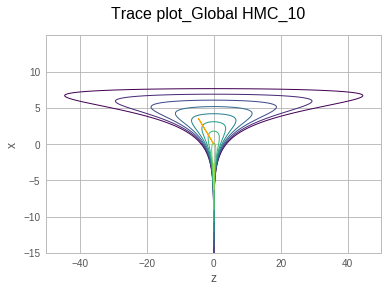

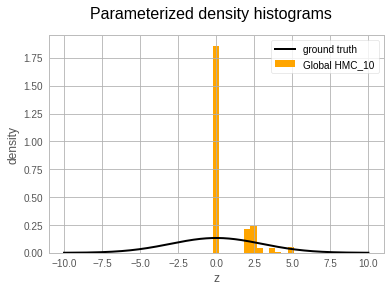

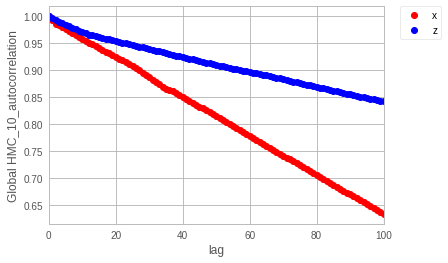

In [173]:
visualize("Global HMC_10",2,samples_hmc_10, model.z(), model.z(),"orange")

## Reference

1. Neal, Radford M. 2003. “Slice Sampling.” Annals of Statistics 31 (3): 705–67.
2. Arora, N. S., Tehrani, N. K., Shah, K. D., Tingley, M., Li, Y. L., Torabi, N., ... & Meijer, E. (2020). Newtonian Monte Carlo: single-site MCMC meets second-order gradient methods. arXiv preprint arXiv:2001.05567.